<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [4]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 98% 116M/119M [00:01<00:00, 97.3MB/s] 
100% 119M/119M [00:01<00:00, 65.9MB/s]


In [5]:
!mv Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/train/adenocarcinoma

!mv Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/train/large.cell.carcinoma

!mv Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/train/squamous.cell.carcinoma

!mv Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/valid/adenocarcinoma

!mv Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/valid/large.cell.carcinoma

!mv Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/valid/squamous.cell.carcinoma

## Preprocesamiento de datos



In [6]:
!mkdir CombinedData
!mkdir CombinedData/adenocarcinoma
!mkdir CombinedData/large.cell.carcinoma
!mkdir CombinedData/normal
!mkdir CombinedData/squamous.cell.carcinoma


!mv Data/train/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/train/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/train/normal/* CombinedData/normal
!mv Data/train/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

!mv Data/test/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/test/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/test/normal/* CombinedData/normal
!mv Data/test/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

!mv Data/valid/adenocarcinoma/* CombinedData/adenocarcinoma/
!mv Data/valid/large.cell.carcinoma/* CombinedData/large.cell.carcinoma/
!mv Data/valid/normal/* CombinedData/normal
!mv Data/valid/squamous.cell.carcinoma/* CombinedData/squamous.cell.carcinoma/

In [7]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Directorio raíz que contiene todas las imágenes combinadas
combined_data_dir = 'CombinedData'

# Directorio de salida para almacenar los conjuntos de train, test y valid
output_dir = 'Data'
os.makedirs(output_dir, exist_ok=True)

# Lista de clases
classes = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Proporciones de división de datos
train_ratio = 0.75
test_ratio = 0.15
validation_ratio = 0.1

# Iterar sobre cada clase
for class_name in classes:
    class_dir = os.path.join(combined_data_dir, class_name)
    images = os.listdir(class_dir)

    # Dividir las imágenes en conjuntos de train, test y valid
    train_images, test_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    test_images, validation_images = train_test_split(test_images, test_size=(validation_ratio / (1 - train_ratio)), random_state=42)

    # Crear directorios de salida para train, test y valid
    train_dir = os.path.join(output_dir, 'train', class_name)
    test_dir = os.path.join(output_dir, 'test', class_name)
    validation_dir = os.path.join(output_dir, 'valid', class_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)

    # Mover imágenes a los directorios correspondientes
    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_dir, image))
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, image))
    for image in validation_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(validation_dir, image))


In [8]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [9]:
input_size = (224, 224)

training_datagen = ImageDataGenerator(dtype='float32',)
test_datagen = ImageDataGenerator( dtype='float32')
validation_datagen = ImageDataGenerator( dtype='float32')

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

Found 674 images belonging to 4 classes.
Found 134 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [10]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 5,
                               restore_best_weights = True)
epochs = 100
history = model.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])



Epoch 1/100
22/22 [==============================] - 28s 378ms/step - loss: 1.1608 - accuracy: 0.6558 - val_loss: 65.8603 - val_accuracy: 0.1739
Epoch 2/100
22/22 [==============================] - 5s 205ms/step - loss: 0.3136 - accuracy: 0.8976 - val_loss: 23.5797 - val_accuracy: 0.1739
Epoch 3/100
22/22 [==============================] - 5s 203ms/step - loss: 0.1306 - accuracy: 0.9674 - val_loss: 2.2904 - val_accuracy: 0.4565
Epoch 4/100
22/22 [==============================] - 6s 247ms/step - loss: 0.0868 - accuracy: 0.9659 - val_loss: 1.4541 - val_accuracy: 0.6630
Epoch 5/100
22/22 [==============================] - 5s 201ms/step - loss: 0.0918 - accuracy: 0.9733 - val_loss: 6.3284 - val_accuracy: 0.4891
Epoch 6/100
22/22 [==============================] - 5s 212ms/step - loss: 0.0846 - accuracy: 0.9688 - val_loss: 0.7597 - val_accuracy: 0.7935
Epoch 7/100
22/22 [==============================] - 5s 217ms/step - loss: 0.0648 - accuracy: 0.9792 - val_loss: 1.0701 - val_accuracy: 0.8

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [15]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 251ms/step - loss: 0.6273 - accuracy: 0.7910


[0.627252459526062, 0.7910447716712952]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

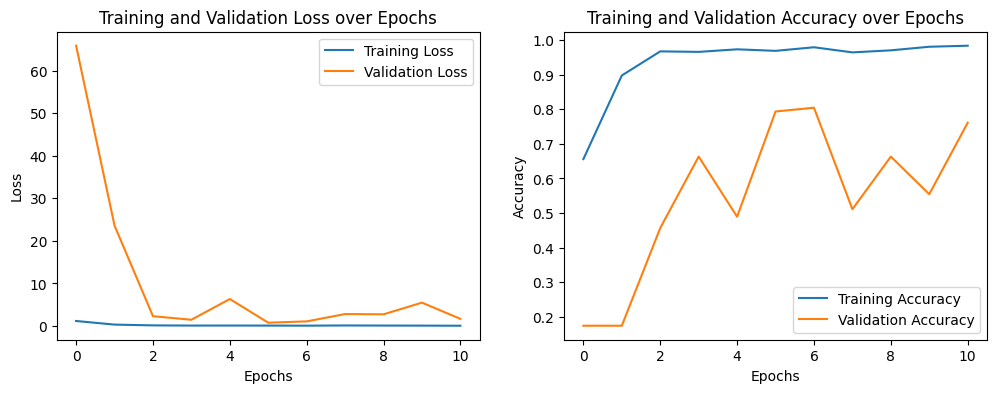

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

5/5 [==============================] - 2s 159ms/step
[[44  3  2  0]
 [ 1 23  0  0]
 [ 1  2 21  0]
 [ 6 11  2 18]]


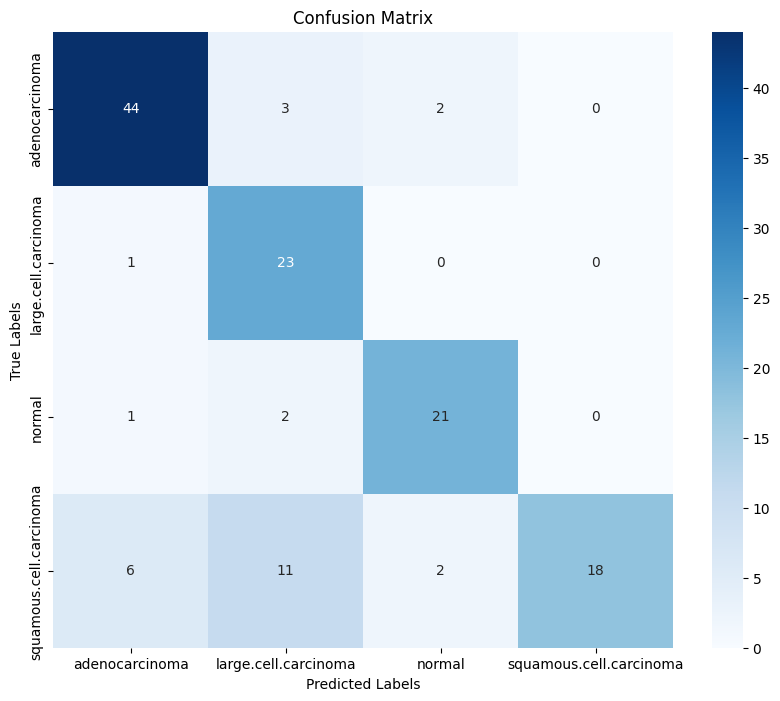

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
num_batches = len(test_generator)

for i in range(num_batches):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))

true_labels = np.array(true_labels)

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Ajuste de modelo

In [72]:
base_model_ = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (224, 224, 3))

for layer in base_model.layers[:-5]:
  layer.trainable = True

In [73]:
from tensorflow.keras.regularizers import l2

model_ajusted = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model_ajusted.add(base_model_)
model_ajusted.add(Dropout(0.6))
model_ajusted.add(Flatten())
model_ajusted.add(BatchNormalization())
model_ajusted.add(Dropout(0.6))

model_ajusted.add(Dense(num_classes, activation='softmax'))

In [74]:
model_ajusted.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001, amsgrad=True),
              metrics=['accuracy'])

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss',
                              verbose = 1,
                               patience = 5,)


checkpoint = ModelCheckpoint(filepath='./transfer_model.hdf5',
                               monitor='val_loss',
                               verbose = 1,
                               save_best_only=True)
epochs = 100
history_ajusted = model_ajusted.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping])


Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 2.4474 - accuracy: 0.2834
Epoch 1: val_loss improved from inf to 1.60422, saving model to ./transfer_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 48s 736ms/step - loss: 2.4474 - accuracy: 0.2834 - val_loss: 1.6042 - val_accuracy: 0.4130
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 2.2252 - accuracy: 0.3175
Epoch 2: val_loss improved from 1.60422 to 1.48323, saving model to ./transfer_model.hdf5
22/22 [==============================] - 15s 690ms/step - loss: 2.2252 - accuracy: 0.3175 - val_loss: 1.4832 - val_accuracy: 0.4022
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.9235 - accuracy: 0.3991
Epoch 3: val_loss improved from 1.48323 to 1.34970, saving model to ./transfer_model.hdf5
22/22 [==============================] - 14s 634ms/step - loss: 1.9235 - accuracy: 0.3991 - val_loss: 1.3497 - val_accuracy: 0.4674
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 1.8041 - accuracy: 0.4555
Epoch 4: val_loss improved from 1.34970 to 1.21645, saving model to ./transfer_model.hdf5
22/22 [==============================] - 17s 776m

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [77]:
model_ajusted.evaluate(test_generator)

5/5 [==============================] - 1s 136ms/step - loss: 0.2574 - accuracy: 0.9328


[0.2574312686920166, 0.9328358173370361]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

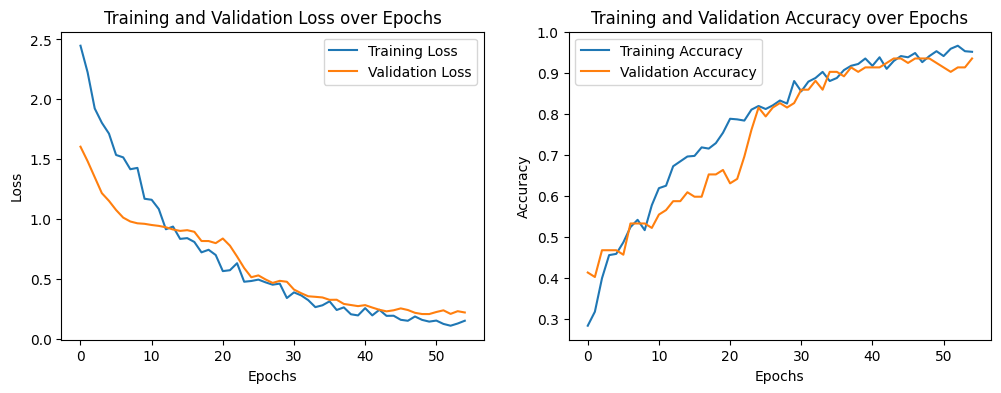

In [78]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ajusted.history['loss'], label='Training Loss')
plt.plot(history_ajusted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_ajusted.history['accuracy'], label='Training Accuracy')
plt.plot(history_ajusted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

5/5 [==============================] - 2s 158ms/step


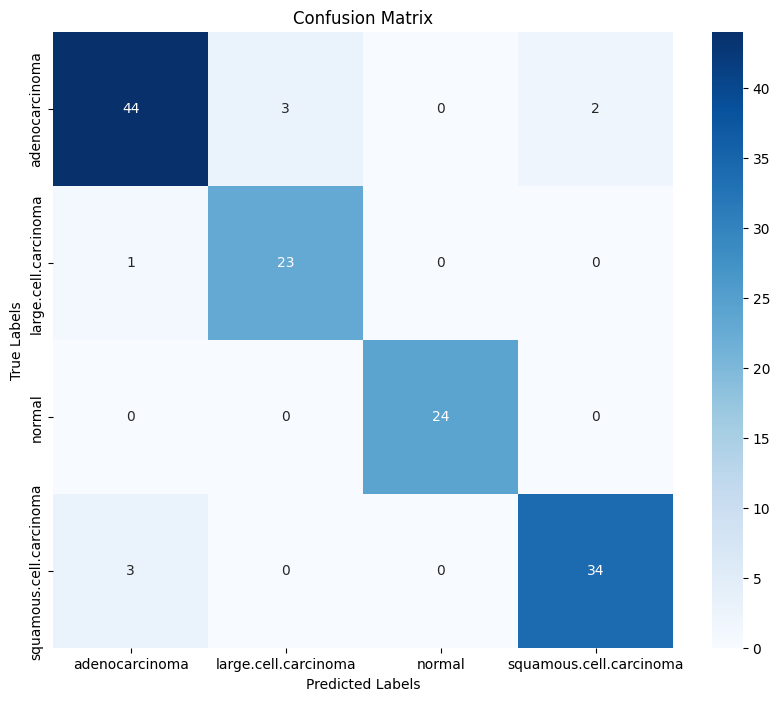

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
num_batches = len(test_generator)

for i in range(num_batches):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))

true_labels = np.array(true_labels)

predictions = model_ajusted.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Prueba del modelo



In [122]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def test_model(model, image_path, target_size=(224, 224)):
    # Create an ImageDataGenerator with the same preprocessing as in training
    test_datagen = ImageDataGenerator(dtype='float32')

    # Load and preprocess the image using the ImageDataGenerator
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = test_datagen.standardize(img_array)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)

    # Map the predicted class index to class label
    class_labels = list(train_generator.class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image along with the predicted class
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class_label}')
    plt.show()

In [119]:
print(list(train_generator.class_indices.keys())[0])
print(list(test_generator.class_indices.keys()))

adenocarcinoma
['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


1/1 [==============================] - 0s 47ms/step


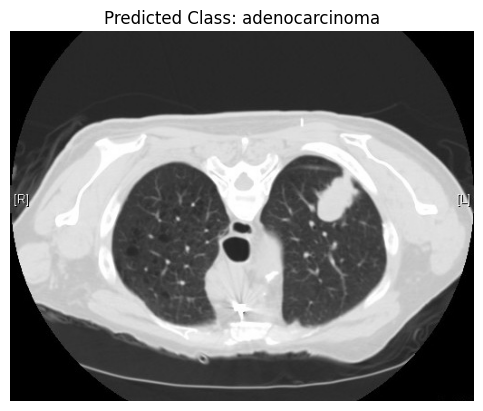

In [127]:
test_model(model = model_ajusted, image_path='./scan.jpg')